# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 3

* env: 
    * fyp2026 (Python 3.11.11) 
    * fpytorch (Python 3.11.11)

In [2]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter3()
# This is needed to render the plots in this chapter
from plots.chapter3 import *

In [3]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

from stepbystep.v0 import StepByStep

In [4]:
print(torch.__version__)

2.2.2+cu121


# A Simple Classification Problem

## Data Generation

### `train_test_split()` - split is the first thing

In [5]:
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)

### `StandardScaler()` - only for X_train
### `.transform()` - avoid val/test_data leakage 

In [6]:
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

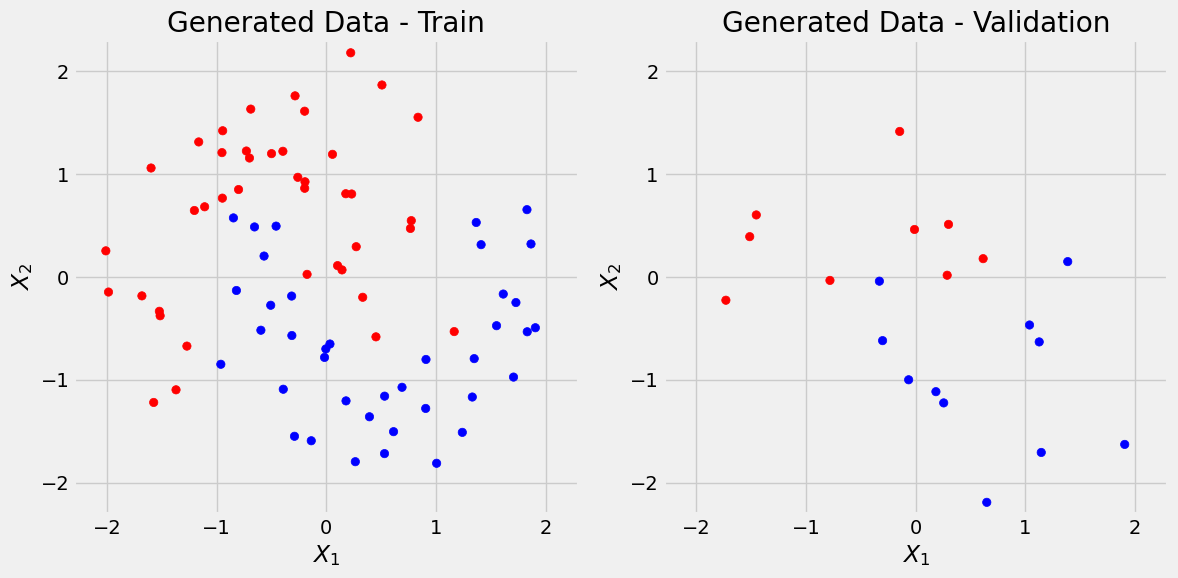

In [7]:
fig = figure1(X_train, y_train, X_val, y_val)

## Data Preparation

### `torch.as_tensor()`
### `TensorDataset(x, y)`
### `Dataloader(dataset= , batch_size= , shuffle=True/False)`

In [8]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

## Model

$$
\Large
y = b + w_1x_1 + w_2x_2 + \epsilon
$$

$$
\Large 
y =
\begin{cases}
1,\ \text{if }b + w_1x_1 + w_2x_2 \ge 0
\\
0,\ \text{if }b + w_1x_1 + w_2x_2 < 0
\end{cases}
$$

### Logits

$$
\Large
z = b + w_1x_1 + w_2x_2
$$

### Probabilities

$$
\Large
\begin{aligned}
& \text{P}(y=1) \approx 1.0, & \text{if } &z \gg 0
\\
& \text{P}(y=1) = 0.5, & \text{if } &z = 0
\\
& \text{P}(y=1) \approx 0.0, & \text{if } &z \ll 0
\end{aligned}
$$

### Odds Ratio - 比值比 = 成功概率(p) / 失败概率(q)

$$
\Large \text{odds ratio }(p) = \frac{p}{q} = \frac{p}{1-p}
$$

In [9]:
def odds_ratio(prob):
    return prob / (1 - prob)

In [10]:
p = .75
q = 1 - p
odds_ratio(p), odds_ratio(q)

(3.0, 0.3333333333333333)

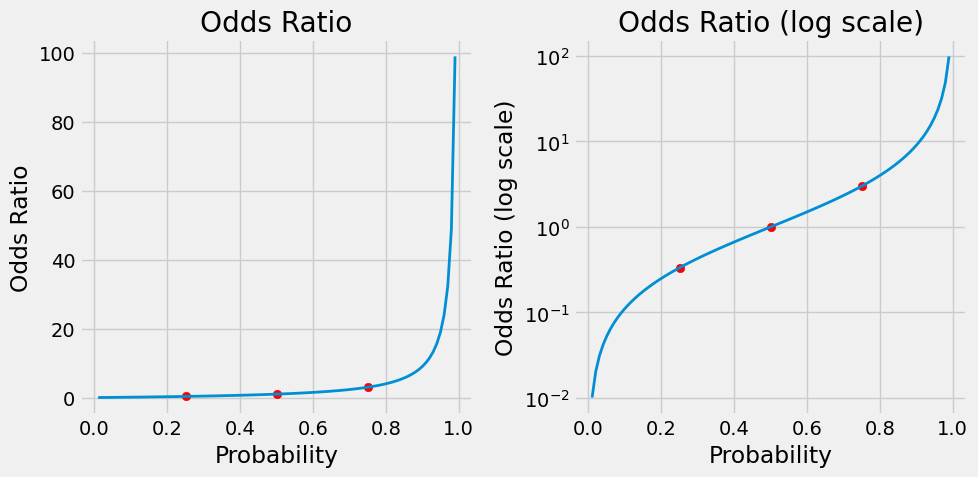

In [11]:
fig = figure2(p)

### Log Odds Ratio - `logit: 对数比值比`

$$
\Large \text{log odds ratio }(p) = \text{log}\left(\frac{p}{1-p}\right)
$$

### a. `log()`

In [12]:
np.log(3)

1.0986122886681098

In [13]:
def log_odds_ratio(prob):
    return np.log(odds_ratio(prob))

p = .75
q = 1 - p
log_odds_ratio(p), log_odds_ratio(q)

(1.0986122886681098, -1.0986122886681098)

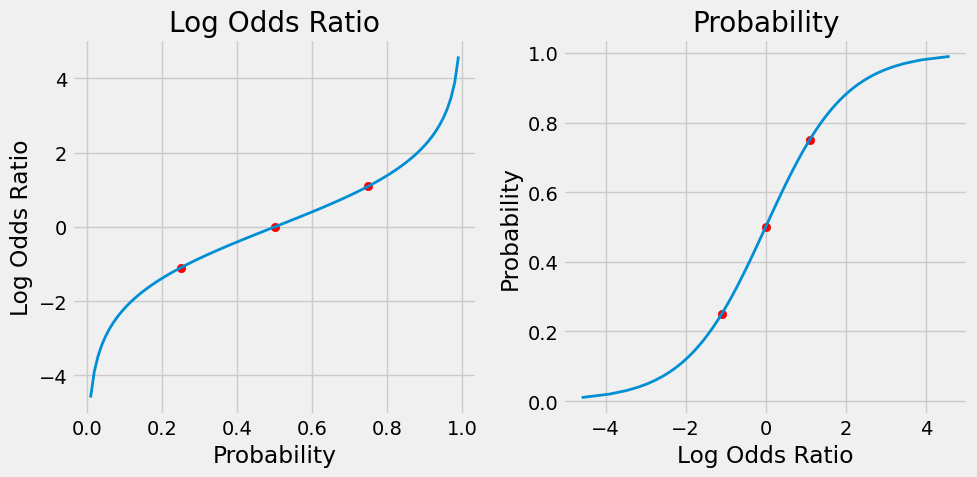

In [14]:
fig = figure3(p)

### From Logits to Probabilities

$$
\Large
\begin{aligned}
b + w_1x_1 + w_2x_2 = &\ z = \text{log}\left(\frac{p}{1-p}\right) \nonumber
\\
e^{b + w_1x_1 + w_2x_2} = &\ e^z = \frac{p}{1-p} \nonumber
\end{aligned}
$$

$$
\Large
\begin{aligned}
\frac{1}{e^z}& = \frac{1-p}{p}
\\
e^{-z}& = \frac{1}{p} - 1
\\
1 + e^{-z}& = \frac{1}{p}&
\\
p& = \frac{1}{1 + e^{-z}}
\end{aligned}
$$

$$
\Large
p = \sigma(z) = \frac{1}{1+e^{-z}}
$$

In [15]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

p = .75
q = 1 - p
sigmoid(log_odds_ratio(p)), sigmoid(log_odds_ratio(q))

(0.75, 0.25)

### Sigmoid - 对数比值比的倒数

In [16]:
torch.sigmoid(torch.tensor(1.0986)), torch.sigmoid(torch.tensor(-1.0986))

(tensor(0.7500), tensor(0.2500))

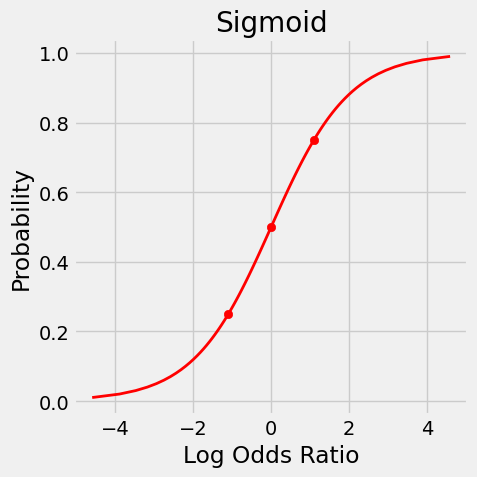

In [17]:
fig = figure4(p)

`激活函数`：非线性函数在神经网络中起着`基本作用`，没有非线性函数就没有神经网络

### Logistic Regression

$$
\Large
\text{P}(y=1) = \sigma(z) = \sigma(b+w_1x_1+w_2x_2)
$$

![](images/logistic_model.png)

In [18]:
torch.manual_seed(42)
model1 = nn.Sequential()
model1.add_module('linear', nn.Linear(2, 1))
model1.add_module('sigmoid', nn.Sigmoid())
print(model1.state_dict())

OrderedDict([('linear.weight', tensor([[0.5406, 0.5869]])), ('linear.bias', tensor([-0.1657]))])


### A Note on Notation

$$
\Large W =
\underset{(3 \times 1)}{
\begin{bmatrix}
b \\
w_1 \\
w_2
\end{bmatrix}};
X = 
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
$$

$$
\Large 
\begin{aligned}
z
& = W^T X
=
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
= \underset{(1 \times 3)}{
\begin{bmatrix}
b & w_1 & w_2
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}\\
& = b + w_1x_1 + w_2x_2
\end{aligned}
$$

## Loss - 二元交叉熵损失 `BCE`: Binary Cross Entropy

$$
\Large y_i = 1 \Rightarrow \text{error}_i=\text{log}(\text{P}(y_i=1))
$$

$$
\Large \text{P}(y_i=0)=1-\text{P}(y_i=1)
$$

$$
\Large y_i = 0 \Rightarrow \text{error}_i=\text{log}(1-\text{P}(y_i=1))
$$

$$
\Large
\text{BCE}(y)={-\frac{1}{(N_{\text{pos}}+N_{\text{neg}})}\Bigg[{\sum_{i=1}^{N_{\text{pos}}}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_{\text{neg}}}{\text{log}(1 - \text{P}(y_i=1))}}\Bigg]}
$$

In [19]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# Positive class (labels == 1)
positive_pred = dummy_predictions[dummy_labels == 1]
first_summation = torch.log(positive_pred).sum()

# Negative class (labels == 0)
negative_pred = dummy_predictions[dummy_labels == 0]
second_summation = torch.log(1 - negative_pred).sum()

# n_total = n_pos + n_neg
n_total = dummy_labels.size(0)

# BCE loss: average of the positive and negative losses
loss = -(first_summation + second_summation) / n_total
loss

tensor(0.1643)

$$
\Large
\text{BCE}(y)={-\frac{1}{N}\sum_{i=1}^{N}{\left[y_i \text{log}(\text{P}(y_i=1)) + (1-y_i) \text{log}(1-\text{P}(y_i=1))\right]}}
$$

In [20]:
summation = torch.sum(
    dummy_labels * torch.log(dummy_predictions) +
    (1 - dummy_labels) * torch.log(1 - dummy_predictions)
)
loss = -summation / n_total
loss

tensor(0.1643)

### BCELoss - `nn.BCELoss()`: 高级函数

* reduction = mean / sum / none

In [21]:
loss_fn = nn.BCELoss(reduction='mean')

loss_fn

BCELoss()

### BCELoss: `loss_fn(prediction, label)`
### MSELoss: `loss_fn(yhat, y_train)`

In [22]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# RIGHT
right_loss = loss_fn(dummy_predictions, dummy_labels)

# WRONG
wrong_loss = loss_fn(dummy_labels, dummy_predictions)

print(right_loss, wrong_loss)

tensor(0.1643) tensor(15.0000)


### BCEWithLogitsLoss

In [23]:
loss_fn_logits = nn.BCEWithLogitsLoss(reduction='mean')

loss_fn_logits

BCEWithLogitsLoss()

In [24]:
logit1 = log_odds_ratio(.9)
logit2 = log_odds_ratio(.2)

dummy_labels = torch.tensor([1.0, 0.0])
dummy_logits = torch.tensor([logit1, logit2])

print(dummy_logits)

tensor([ 2.1972, -1.3863], dtype=torch.float64)


In [25]:
loss = loss_fn_logits(dummy_logits, dummy_labels)
loss

tensor(0.1643)

**Note:**
* option 1: final layer `with nn.Sigmoid` --> output: `p`, loss_fn is `nn.BCELoss`
* option 2: final layer `without nn.Sigmoid` --> output: `logit`, loss_fn is `nn.BCEWithLogitsLoss` --> `prefered`

### Imbalanced Dataset

In [26]:
dummy_imb_labels = torch.tensor([1.0, 0.0, 0.0, 0.0])
dummy_imb_logits = torch.tensor([logit1, logit2, logit2, logit2])

$$
\Large
\begin{aligned}
\text{pos-weight} = \frac{\text{points in negative class}}{\text{points in positive class}}
\end{aligned}
$$

In [27]:
n_neg = (dummy_imb_labels == 0).sum().float()
n_pos = (dummy_imb_labels == 1).sum().float()

pos_weight = (n_neg / n_pos).view(1,)
pos_weight

tensor([3.])

In [28]:
loss_fn_imb = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight)

In [29]:
loss = loss_fn_imb(dummy_imb_logits, dummy_imb_labels)
loss

tensor(0.2464)

$$
\Large \text{weighted average} = \frac{\text{pos-weight} \cdot \sum_{i=1}^{N_{\text{pos}}}{\text{loss}_i}+\sum_{i=1}^{N_{\text{neg}}}{\text{loss}_i}}{\text{pos-weight} \cdot N_{\text{pos}}+N_{\text{neg}}}
$$

$$ \Large \text{BCEWithLogitsLoss} = \frac{\text{pos-weight} \cdot \sum_{i=1}^{N_{\text{pos}}}{\text{loss}_i} + \sum_{i=1}^{N_{\text{neg}}}{\text{loss}_i}}{N_{\text{pos}} + N_{\text{neg}}} $$

In [30]:
loss_fn_imb_sum = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=pos_weight)

loss = loss_fn_imb_sum(dummy_imb_logits, dummy_imb_labels)

# pos_weight is used to normalize the loss
loss = loss / (pos_weight * n_pos + n_neg)
loss

tensor([0.1643])

## Model Configuration

In [31]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

## Model Training

In [32]:
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

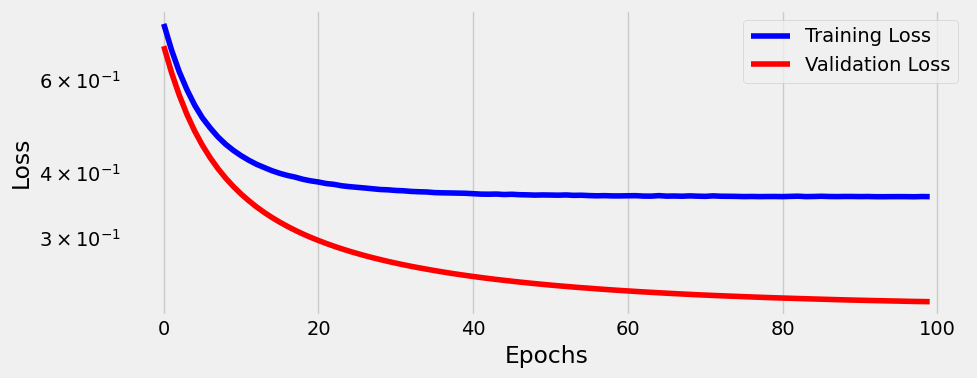

In [33]:
fig = sbs.plot_losses()

In [34]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1806, -1.8693]], device='cuda:0')), ('linear.bias', tensor([-0.0591], device='cuda:0'))])


$$
\large
\begin{array}{ccccccc}
z & = & b & + & w_1x_1 & + & w_2x_2
\\
z & = & -0.0587 & + & 1.1822x_1 & - & 1.8684x_2
\end{array}
$$

#### Making Predictions (Logits)

In [35]:
predictions = sbs.predict(x_train_tensor[:4])
predictions

array([[ 0.20345594],
       [ 2.9444456 ],
       [ 3.693318  ],
       [-1.2334074 ]], dtype=float32)

#### Making Predictions (Probabilities)

In [36]:
probabilities = sigmoid(predictions)
probabilities

array([[0.5506892],
       [0.9500003],
       [0.9757152],
       [0.2255856]], dtype=float32)

#### Making Predictions (Classes)

$$
\Large y =
\begin{cases}
1,\ \text{if P}(y=1) \ge 0.5
\\
0,\ \text{if P}(y=1) < 0.5
\end{cases}
$$

$$
\Large y =
\begin{cases}
1,\ \text{if } \sigma(z) \ge 0.5
\\
0,\ \text{if } \sigma(z) < 0.5
\end{cases}
$$

$$
\Large y =
\begin{cases}
1,\ \text{if } z \ge 0
\\
0,\ \text{if } z < 0
\end{cases}
$$

In [37]:
# predictions are the logits
classes = (predictions >= 0).astype(int)
classes

array([[1],
       [1],
       [1],
       [0]])

In [38]:
# probabilities used for classification
classes = (probabilities >= 0.5).astype(int)
classes

array([[1],
       [1],
       [1],
       [0]])

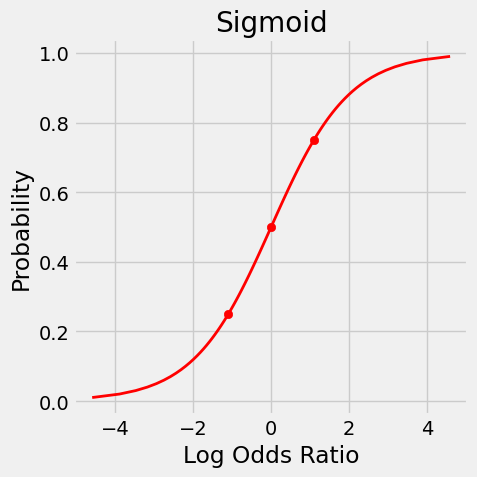

In [39]:
# again: p = sigmoid(logit), logit = log_odds_ratio(p) = log(p / (1 - p))
fig = figure4(p)

## Decision Boundary - 决策边界 / 20250410

$$
\Large
\begin{array}{ccccccccc}
z & = &   0 & =   & b & + & w_1x_1 & + & w_2x_2
\\
& & -w_2x_2 & = & b & + & w_1x_1 & &
\\
& & x_2 & = & -\frac{b}{w_2} & - &\frac{w_1}{w_2}x_1 & &
\end{array}
$$

$$
\Large
\begin{array}{ccccccccc}
& & x_2 & = & -\frac{0.0587}{1.8684} & + &\frac{1.1822}{1.8684}x_1 & &
\\
& & x_2 & = & -0.0314 & + &0.6327x_1 & &
\end{array}
$$

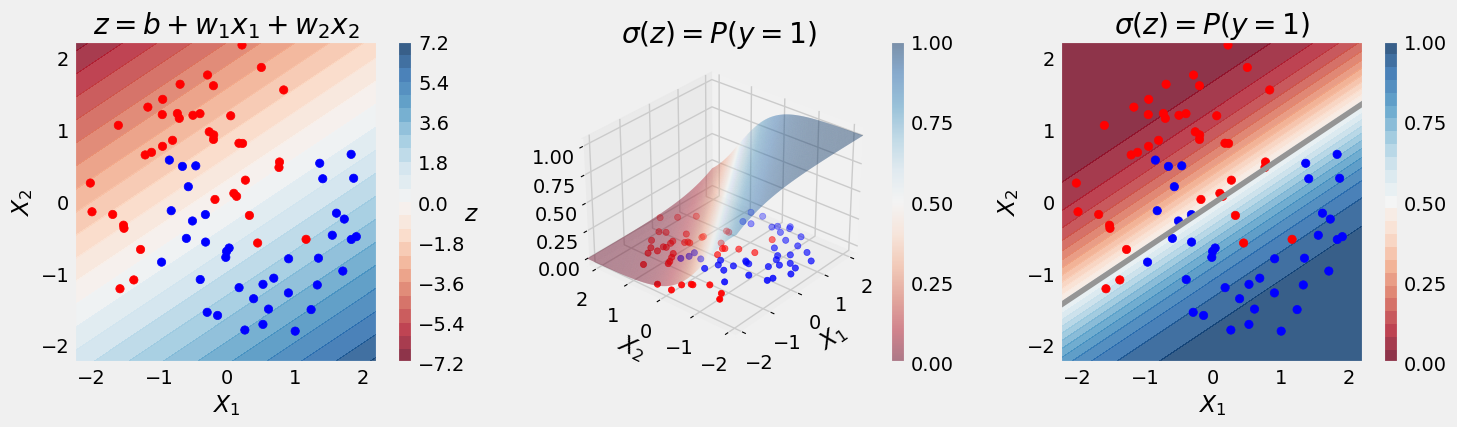

In [40]:
# Training set
fig = figure7(X_train, y_train, sbs.model, sbs.device)

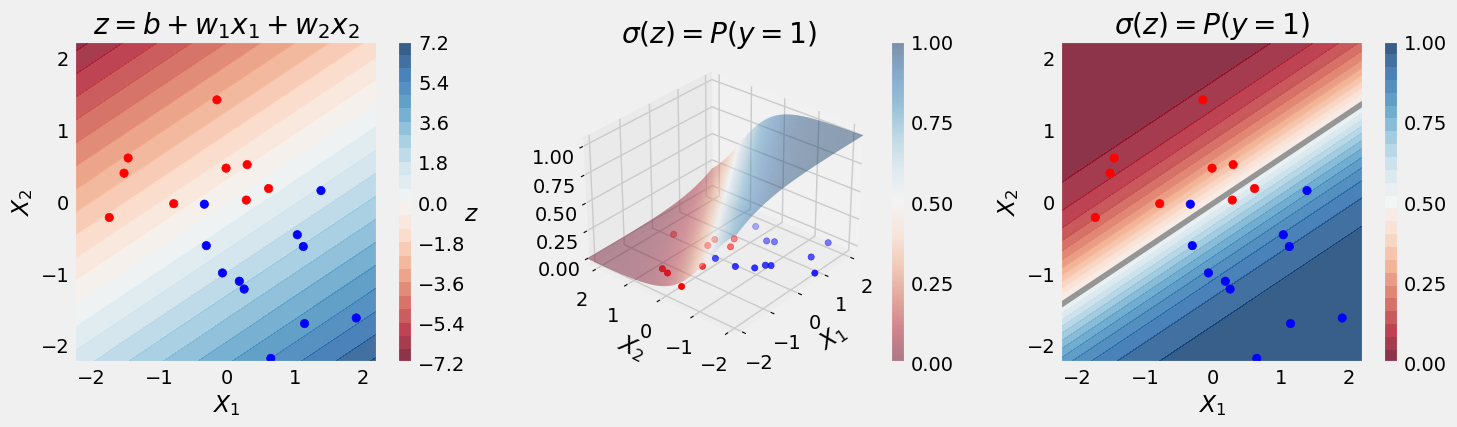

In [41]:
# Validation set
fig = figure7(X_val, y_val, sbs.model, sbs.device)

* 逻辑回归总是用一条直线分割两个类别
* 类别越可分离，损失就越低

### Are my data points separable?

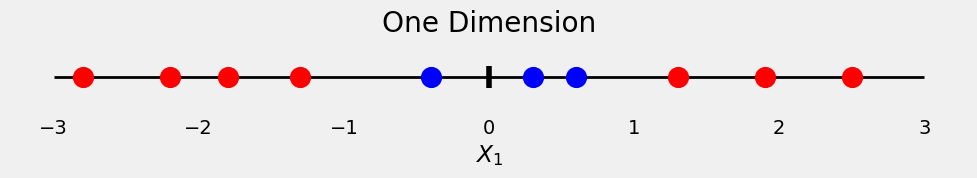

In [42]:
x = np.array([-2.8, -2.2, -1.8, -1.3, -.4, 0.3, 0.6, 1.3, 1.9, 2.5])
y = np.array([0., 0., 0., 0., 1., 1., 1., 0., 0., 0.])

fig = one_dimension(x, y)

$$
\Large X_2 = f(X_1)= X_1^2
$$

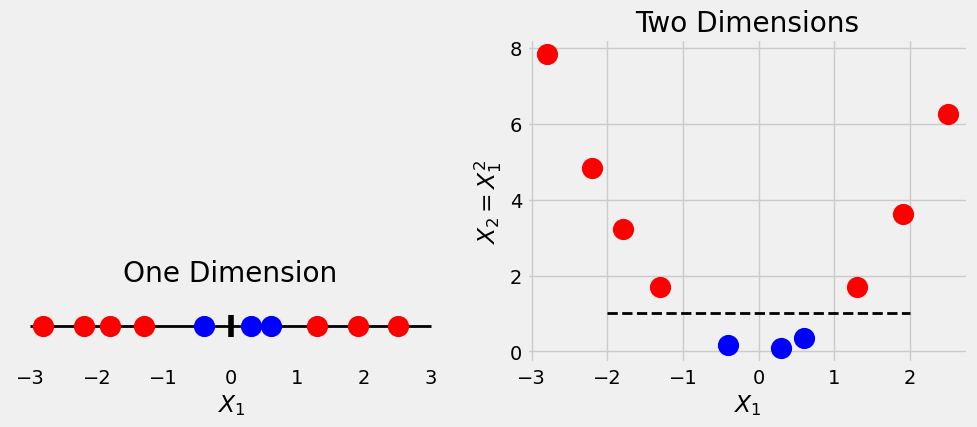

In [43]:
fig = two_dimensions(x, y)

* 维数越多，点的可分性越强
* 随着维数的增加，空的空间越来越多。--> 数据点相距较远，更容易划分开
* SVM-支持向量机的内核技巧：`内核`只不过是用来创建附加维度的函数
* 神经网络也可以增加维度，添加的隐藏层单元数多于特征数，就会发生维度大于特征数

In [44]:
model = nn.Sequential()
model.add_module('hidden', nn.Linear(2, 10))
model.add_module('activation', nn.ReLU())
model.add_module('output', nn.Linear(10, 1))
model.add_module('sigmoid', nn.Sigmoid())

loss_fn = nn.BCELoss()

* 模型从二维增加到十维，使用十维计算logit，各层间一定需要`激活函数`才有效

## Classification Threshold - 分类阈值

In [45]:
# p.squeeze() removes the last dimension of size 1
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
threshold = 0.5

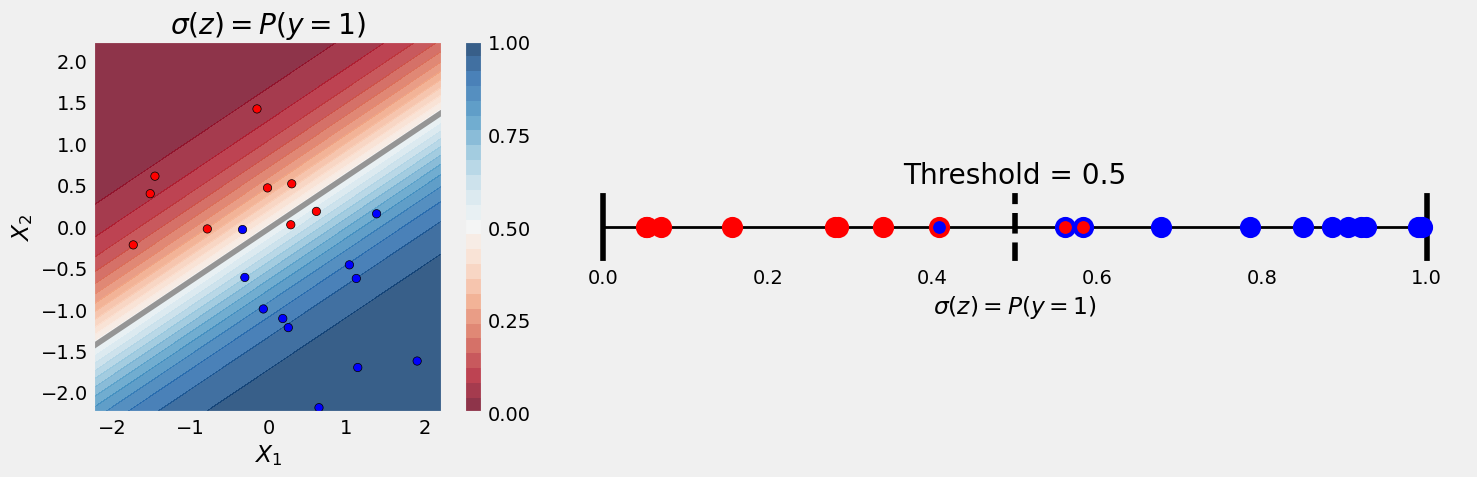

In [46]:
# 概率可视化在一条直线上
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold)

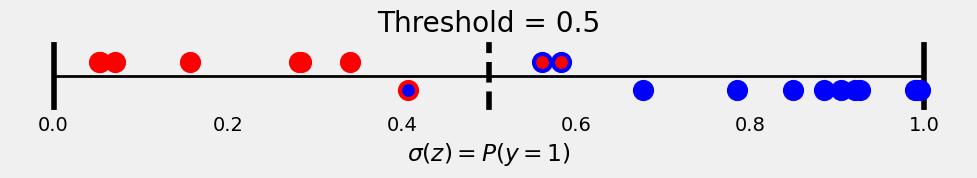

In [47]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, False)

* 决策边界为阀值0.5的垂直虚线

### Confusion Matrix - 混淆矩阵

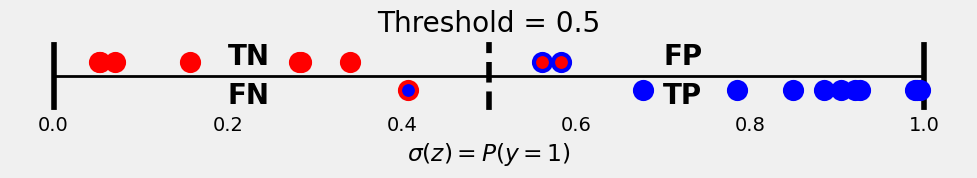

In [48]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, True)

* TN - 真阴性：红点，线上方，概率 < 阈值
* FP - 假阳性：红点蓝圈，线上方，概率 > 阈值

* FN - 假阴性：蓝点红圈，线下方，概率 < 阈值
* TP - 真阳性：蓝点，线下方，概率 > 阈值

* 蓝点（正）在线下方，匹配 Scikit-Learn 的`混淆矩阵约定`

In [49]:
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= .5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]], dtype=int64)

#### True and False Positives and Negatives

In [50]:
def split_cm(cm):
    # Actual negatives go in the top row, 
    # above the probability line
    actual_negative = cm[0]
    # Predicted negatives go in the first column
    tn = actual_negative[0]
    # Predicted positives go in the second column
    fp = actual_negative[1]

    # Actual positives go in the bottow row, 
    # below the probability line
    actual_positive = cm[1]
    # Predicted negatives go in the first column
    fn = actual_positive[0]
    # Predicted positives go in the second column
    tp = actual_positive[1]
    
    return tn, fp, fn, tp

### Metrics - 指标

### True and False Positive Rates - 真假阳性率

$$
\Large \text{TPR} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{FPR} = \frac{\text{FP}}{\text{FP + TN}}
$$

* `TPR`: 真阳性率，即召回率，FN 对结果不利时，改进模型的 TPR-召回率<br>
e.g. Corona 病毒感染者 10人 阳性，模型识别出 9人 阳性，1人 错误识别 为阴性，TPR=9/10=90% --> 改进 TPR 或 召回率 到 100%

* `FRP`：假阳性率，FP 对结果不利时，降低模型的 FPR 指标<br>
e.g. Corona 病毒感染，10人阴性（无感染），模型错误识别出 3人 阳性，7人 正确识别为 阴性，FPR=3/10=30% --> 改进 FPR 到 0%

In [51]:
def tpr_fpr(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    return tpr, fpr

In [53]:
tpr_fpr(cm_thresh50)

(0.9090909090909091, 0.2222222222222222)

### Precision and Recall - 精确率 与 召回率

$$
\Large \text{Recall} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
$$

In [52]:
def precision_recall(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    return precision, recall

In [53]:
precision_recall(cm_thresh50)

(0.8333333333333334, 0.9090909090909091)

### Accuracy - 准确率

$$
\Large \text{Accuracy} = \frac{\text{TP+TN}}{\text{TP+TN+FP+FN}}
$$

## Trade-offs and Curves

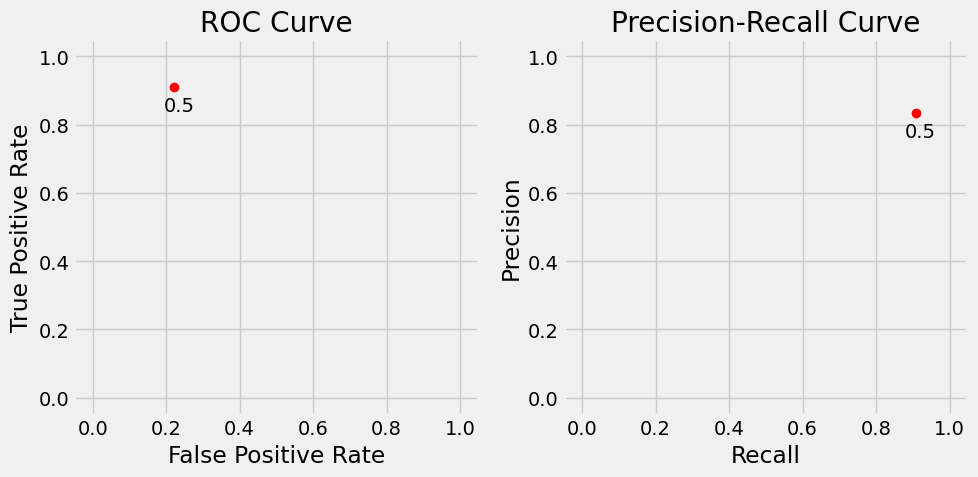

In [54]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.5], annot=True)

* ROC: 接受者操作特征
* PR curve: 精确率-召回率曲线

### Low Threshold - 低阀值

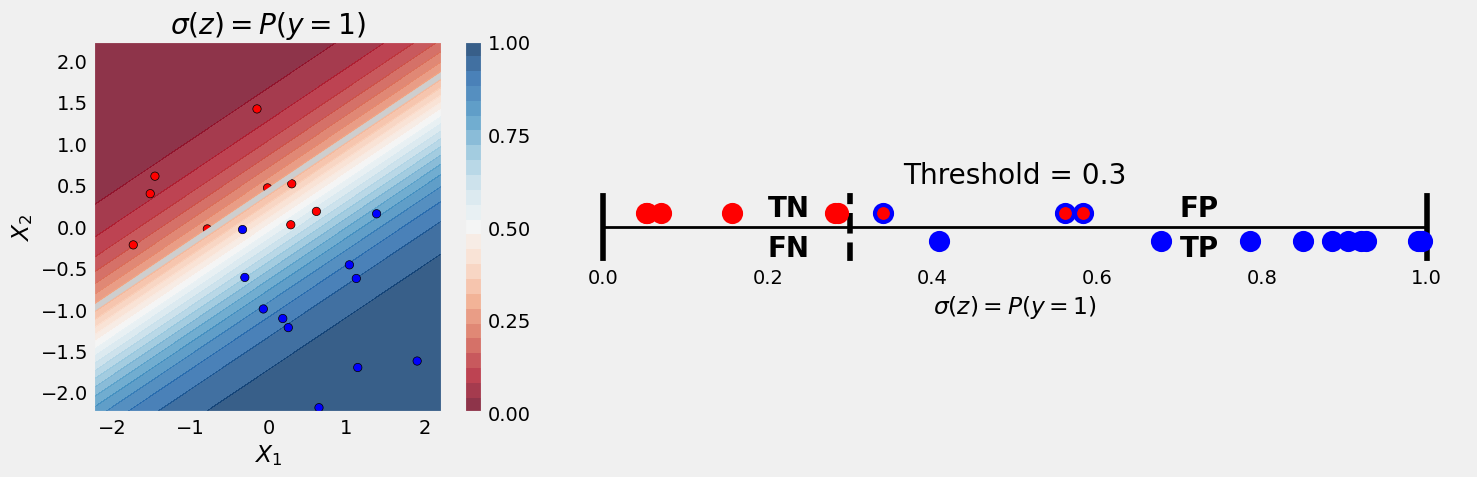

In [55]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.3, shift=0.04, annot=True)

--> 更多的假阳性， 更少的假阴性

In [59]:
# 低阈值 p=0.3, 混淆矩阵
cm_thresh30 = confusion_matrix(y_val, (probabilities_val >= .3))
cm_thresh30

array([[ 6,  3],
       [ 0, 11]], dtype=int64)

In [61]:
tpr_fpr(cm_thresh30)

(1.0, 0.3333333333333333)

In [63]:
precision_recall(cm_thresh30)

(0.7857142857142857, 1.0)

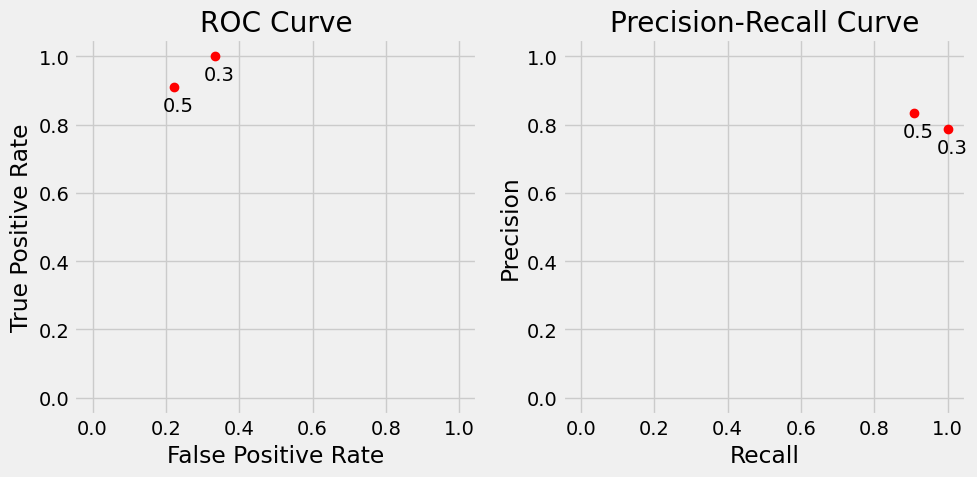

In [57]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5], annot=True)

### High Threshold - 高阈值

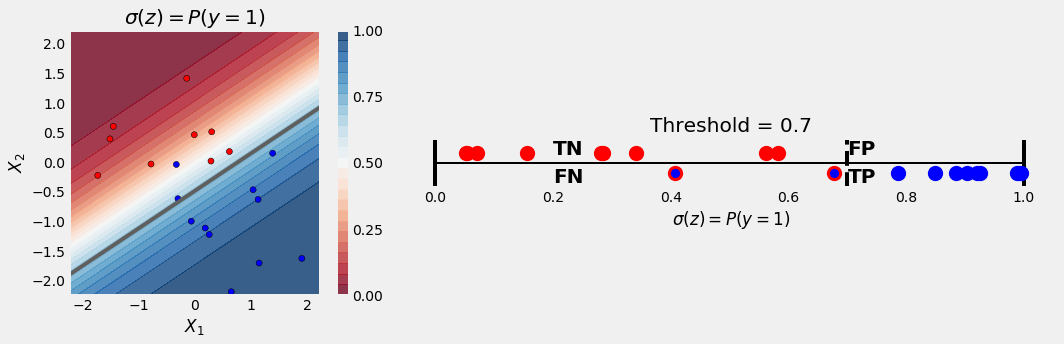

In [54]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.7, shift=0.04, annot=True)

In [67]:
# 低阈值 p=0.7, 混淆矩阵
cm_thresh70 = confusion_matrix(y_val, (probabilities_val >= .7))
cm_thresh70

array([[9, 0],
       [2, 9]], dtype=int64)

In [65]:
tpr_fpr(cm_thresh70)

(0.8181818181818182, 0.0)

In [ ]:
# TPR = Recall
precision_recall(cm_thresh70)

(1.0, 0.8181818181818182)

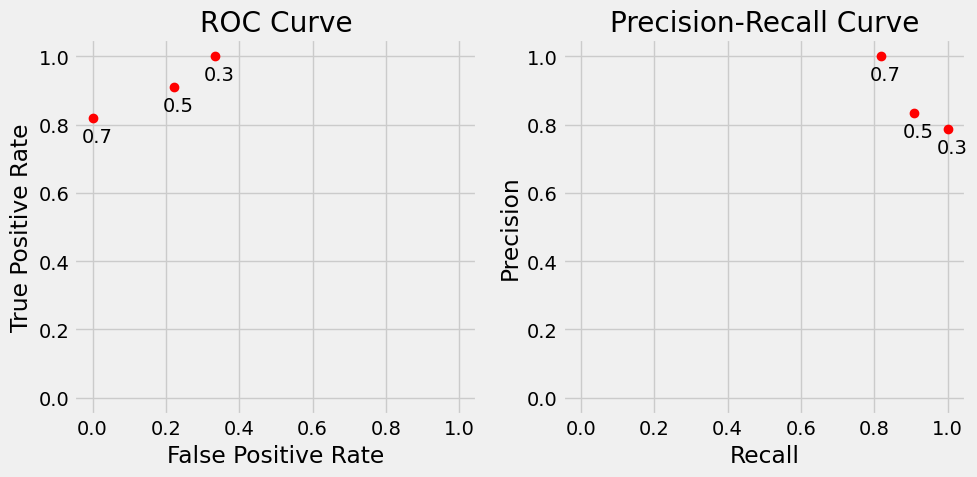

In [68]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5, .7], annot=True)

### ROC and PR Curves

In [69]:
threshs = np.linspace(0.,1,11)

b:\04_Beginner\02_GitHub\fypbjchina\e02_PyTorchStepByStep\plots\chapter3.py:49: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


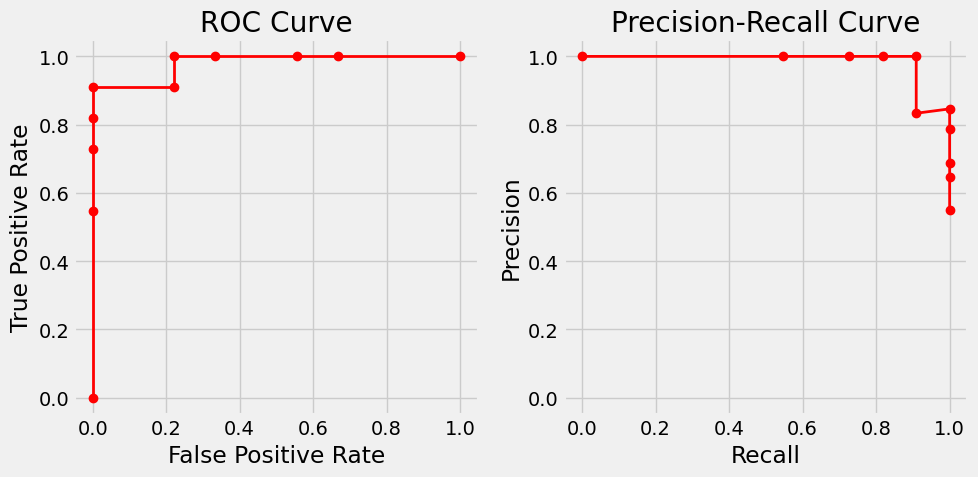

In [70]:
fig = figure17(y_val, probabilities_val, threshs)

In [71]:
fpr, tpr, thresholds1 = roc_curve(y_val, probabilities_val)
prec, rec, thresholds2 = precision_recall_curve(y_val, probabilities_val)

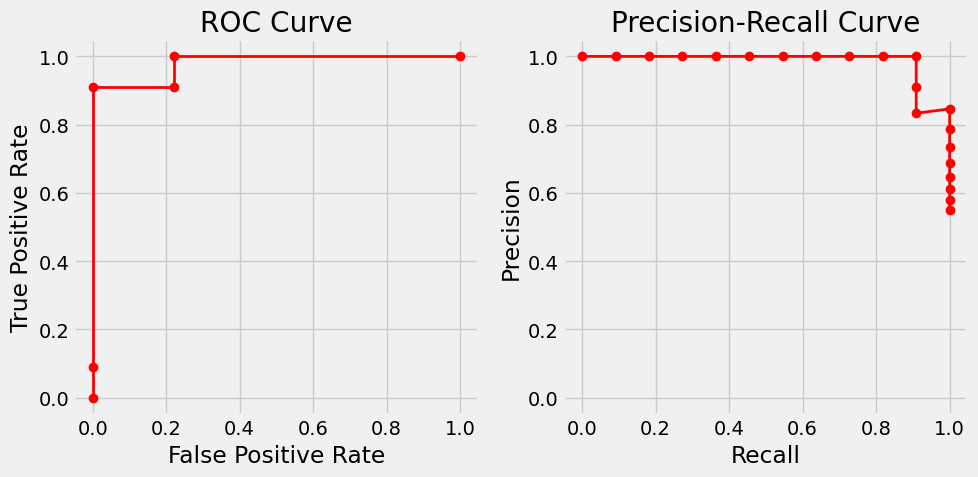

In [72]:
fig = eval_curves(fpr, tpr, rec, prec, thresholds1, thresholds2, line=True)

### The Precision Quirk

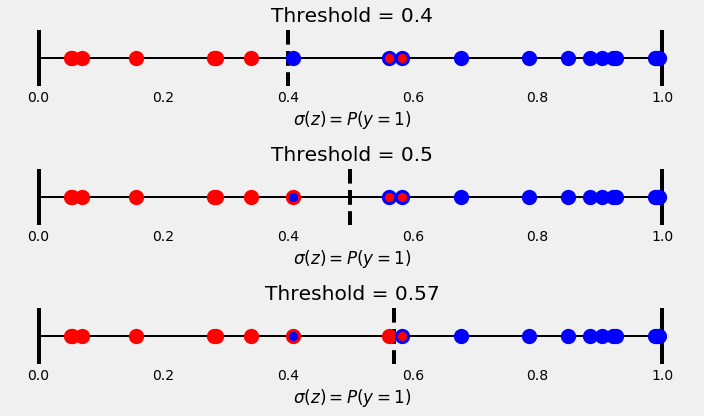

In [61]:
fig = figure19(y_val, probabilities_val)

$$
\Large \text{Precision}(\text{thresh}=0.40)=\frac{13}{13+2}=0.8666
$$

$$
\Large \text{Precision}(\text{thresh}=0.50)=\frac{(13-1)}{(13-1)+2}=\frac{12}{12+2}=0.8571
$$

$$
\Large \text{Precision}(\text{thresh}=0.57)=\frac{12}{12+(2-1)}=\frac{12}{12+1}=0.9230
$$

### Best and Worst Curves

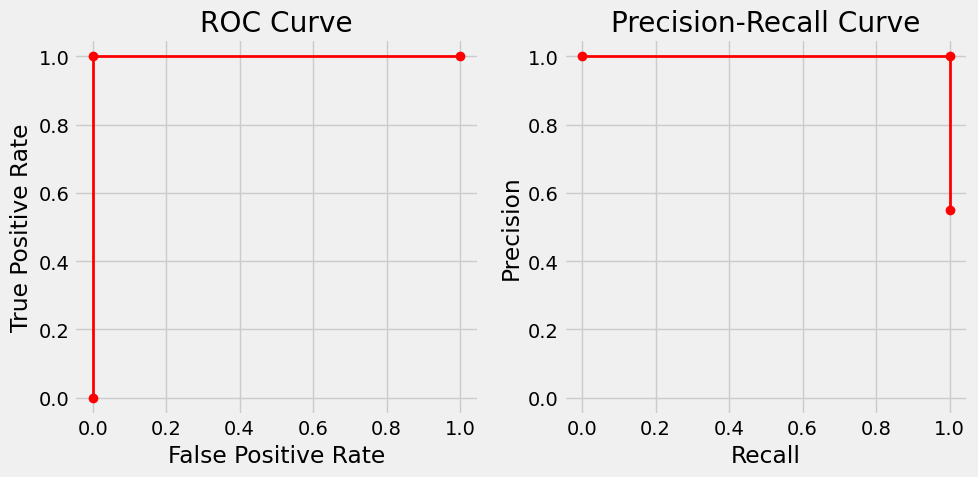

In [73]:
# Best
fig = figure20(y_val)

In [74]:
np.random.seed(39)
random_probs = np.random.uniform(size=y_val.shape)

In [76]:
fpr_random, tpr_random, thresholds1_random = roc_curve(y_val, random_probs)
prec_random, rec_random, thresholds2_random = precision_recall_curve(y_val, random_probs)

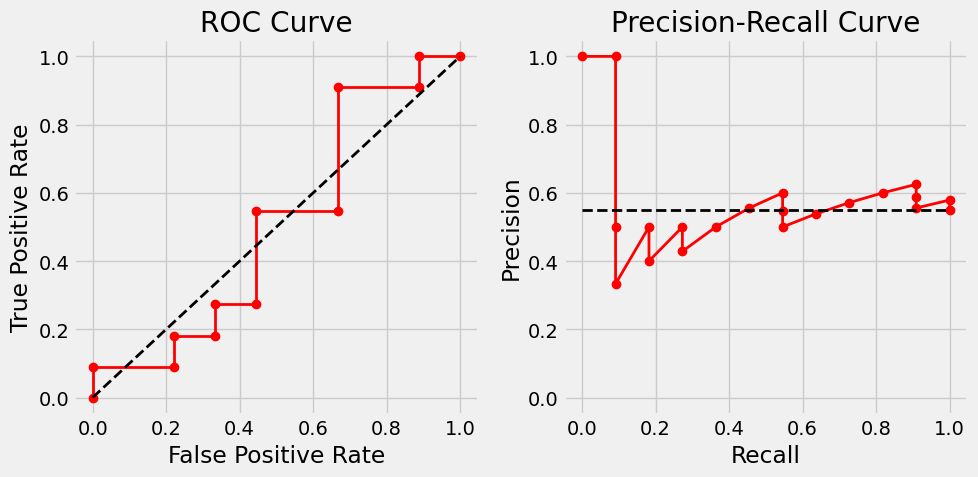

In [77]:
# Worst
fig = figure21(y_val, random_probs)

### Comparing Models

In [78]:
# Area under the curves of our model
auroc = auc(fpr, tpr)
aupr = auc(rec, prec)
print(auroc, aupr)

0.9797979797979798 0.9854312354312356


In [79]:
# Area under the curves of the random model
auroc_random = auc(fpr_random, tpr_random)
aupr_random = auc(rec_random, prec_random)
print(auroc_random, aupr_random)

0.505050505050505 0.570559046216941


## Putting It All Together

In [80]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=16, 
    shuffle=True
)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [81]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

In [82]:
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

In [83]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1806, -1.8693]], device='cuda:0')), ('linear.bias', tensor([-0.0591], device='cuda:0'))])


In [84]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]], dtype=int64)